See overleaf project "U-statistics for speaker discrimination" for the theory.
This is a somewhat brute force implementation.

In [130]:
%matplotlib inline
import itertools
import math
import scipy.special
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import seaborn as sns

# Function computing estimated variance

In [153]:
def psi(M, i, j, k, l):
    n = M.shape[0]
    res = 4*(n-2)*(M[i, j]*M[i, k]-M[i, j]*M[k, l])/(n*(n-1)) + \
          2*(M[i, j]*M[i, j] - M[i, j]*M[k, l])/(n*(n-1))
    return res


def psi_sym(M, i, j, k, l):
    vals = [psi(M, *perm)
                 for perm in itertools.permutations((i, j, k, l))]
    return sum(vals)/float(math.factorial(4))


def estimate_variance_of_the_mean(M):
    """
    Input: 
        M: a matrix containing (symmetrized) order 2 kernel values.
           Should be symmetric, diagonal elements will be ignored.
    """
    # check argument and get dim (n)
    assert len(M.shape) == 2
    n = M.shape[0]
    assert n == M.shape[1]
    for i in range(n):
        for j in range(i+1, n):
            assert math.isclose(M[i, j], M[j, i])
    # compute variance
    vals = [psi_sym(M, *comb)
             for comb in itertools.combinations(range(n), 4)]
    return sum(vals)/float(scipy.special.comb(n, 4, exact=True))


def estimate_mean(M):
    # this is just computing the U-statistic which is the average of the
    # symmetric scores, excluding diagonal elements
    n = M.shape[0]
    return np.mean([M[i, j] for i in range(n) for j in range(i+1, n)])

# Simulation to validate estimation function

In [159]:
# simulation where s1, s2... are normal Gaussian draws and M(s1, s2) is the absolute distance
def simulate(n=10, n_runs=1000):
    # n: number of "speakers"
    # n_runs: number of simulation runs
    var_est = []
    m_est = []
    for seed in range(n_runs):
        #random.seed(seed+200000000)
        # sample data for n speakers
        data = random.randn(n)
        # compute M
        M = np.zeros(shape=(n, n))
        for s1 in range(n):
            for s2 in range(n):       
                M[s1, s2] = np.abs(data[s1]-data[s2])
        # compute variance estimate
        var_est.append(estimate_variance_of_the_mean(M))
        m_est.append(estimate_mean(M))
    return var_est, m_est

In [160]:
# getting data
n_trials = 5
v, m = {}, {}
mu = 2*1/np.sqrt(np.pi)
for i in range(n_trials):
    v[i], m[i] = simulate()
v2, m2 = {}, {}
for i in range(n_trials):
    v2[i], m2[i] = simulate()

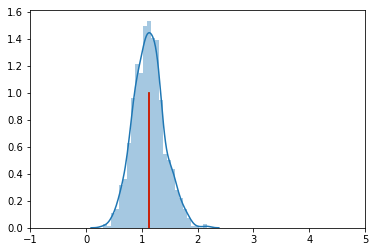

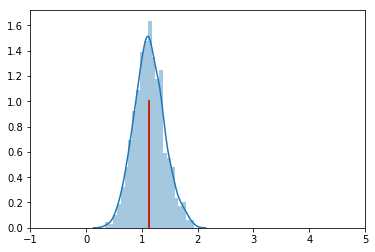

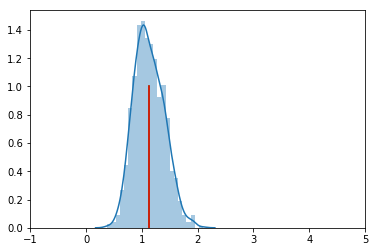

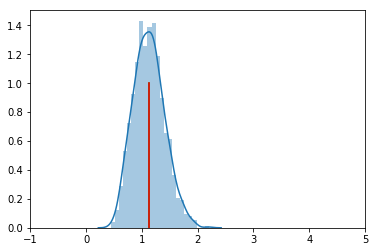

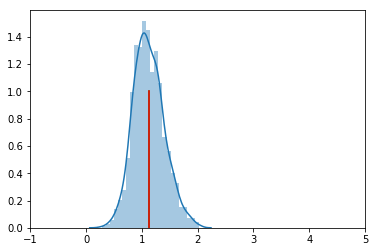

In [161]:
# checking the mean estimation is correct -> looks good
# theory says expected distance should be 2*sigma/sqrt(pi)
# see: https://www.quora.com/What-is-the-expected-distance-between-two-independent-draws-from-a-Normal-distribution
for i in range(n_trials):
    est_mu = np.mean(m[i])
    plt.figure()
    ax = sns.distplot(m[i])
    ax.plot([est_mu, est_mu], [0, 1], 'g')
    ax.plot([mu, mu], [0, 1], 'r')
    ax.set_xlim([-1, 5])

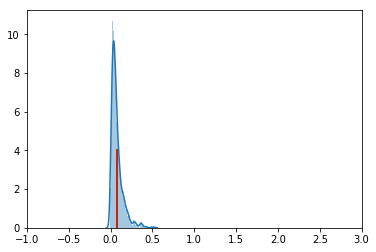

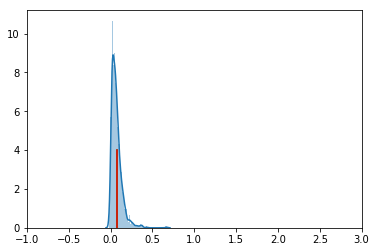

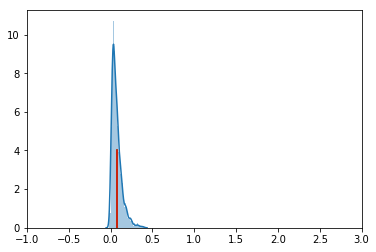

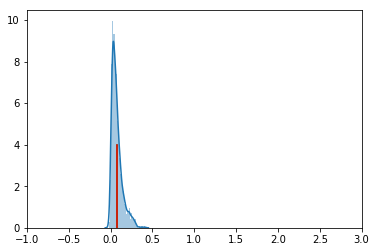

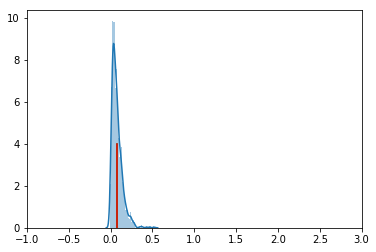

In [162]:
# checking the variance of the mean estimation is correct
for i in range(n_trials):
    obs_v = np.var(m[i])
    est_v = np.mean(v2[i])
    plt.figure()
    ax = sns.distplot(v2[i])
    ax.plot([est_v, est_v], [0, 4], 'g')
    ax.plot([obs_v, obs_v], [0, 4], 'r')
    ax.set_xlim([-1, 3])

In [163]:
for i in range(n_trials):
    print(np.var(m[i]))
    print(np.mean(v[i]))
    print(np.var(m2[i]))
    print(np.mean(v2[i]))

0.0766637566707
0.0775426430563
0.0769784719244
0.0767780943526
0.0718019814559
0.0753714584221
0.0764321098559
0.0721877323584
0.0715740531536
0.0770927168463
0.0754065487794
0.0742229419115
0.0767235703043
0.0723603991187
0.0786781988603
0.0762672327982
0.0760919820591
0.0743455039314
0.074843832854
0.0774246784823


In [165]:
# A different simulation
# Get s_i, s_j as Gaussian samples of sizes n_i, n_j with mean mu_i, mu_j and variance v_i, v_j, where those parameters are drawn from 1+poisson(lam) and uniform distributions on [0, 1] respectively. Then set M[i, j] to the average Euclidean between elements of s_i and s_j.

def simulate(n=5, n_runs=10000, lam=3):
    # n: number of "speakers"
    # n_runs: number of simulation runs
    var_est = []
    m_est = []
    for seed in range(n_runs):
        #random.seed(seed)
        # sample data for n speakers
        data = {}
        for s in range(n):
            siz = 1+random.poisson(lam)
            mu = random.rand()
            var = random.rand()
            data[s] = mu + var*random.randn(siz)
        # compute M
        M = np.zeros(shape=(n, n))
        for s1 in range(n):
            for s2 in range(n):       
                M[s1, s2] = np.mean([np.abs(d2-d1)
                                      for d1 in data[s1]
                                        for d2 in data[s2]])
        # compute variance estimate
        var_est.append(estimate_variance_of_the_mean(M))
        m_est.append(estimate_mean(M))
    return var_est, m_est

In [173]:

ms, vs = {}, {}
for i in range(n_trials):
    ms[i], vs[i] = [], []
n_trials = 5
for n_runs in [1, 10, 100, 1000, 10000]:
    print(n_runs)
    for i in range(n_trials):
        v, m = simulate(n_runs=n_runs)
        ms[i].append(np.var(m))
        vs[i].append(np.mean(v))


1
10
100
1000
10000


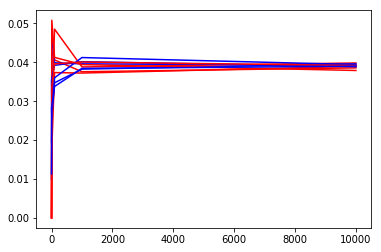

In [174]:
plt.figure()
for i in range(n_trials):
    plt.plot([1, 10, 100, 1000, 10000], ms[i], 'r')
    plt.plot([1, 10, 100, 1000, 10000], vs[i], 'b')

In [175]:
# could continue, looking for example at distribution of bias variance with sample sizes
# but not for now

In [179]:
for i in range(n_trials):
    print(ms[i])
    print(vs[i])

[0.0, 0.04291058956419648, 0.040620867526736708, 0.037572100947251469, 0.038563224095319273]
[0.019376479889073837, 0.048527758188233926, 0.039857657605114366, 0.039601259085224848, 0.039231572835029559]
[0.0, 0.026612494753847145, 0.048521092977444863, 0.038808608735733392, 0.03982355167543649]
[0.035374933769282718, 0.025527725114221279, 0.034733676115945591, 0.038253116418244699, 0.039575090201967922]
[0.0, 0.050809301981063107, 0.041256154350422444, 0.039407275875598398, 0.037898166654420154]
[0.009932591114330213, 0.0357977613499839, 0.039222038101125754, 0.04014829531571347, 0.038861185783053441]
[0.0, 0.017863648971315163, 0.03735310495046467, 0.037235408036551315, 0.038956916836099802]
[0.028291280672600123, 0.025559260312188858, 0.036018415090080184, 0.041219765432514911, 0.039414580100865633]
[0.0, 0.033933883828089248, 0.039585885503926221, 0.040071064446539552, 0.039175317583294733]
[0.011321176854093519, 0.028682779127440806, 0.033784442334267285, 0.038432154249653502, 0.0